In [147]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import math

# VEST NE 2020

## VEST Documentation

### Sources

Election results from the Nebraska Secretary of State's office via email.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program, with the following exceptions.

Cass, Douglas, Harlan, and Lancaster replaced with maps from the counties.

Mergers and/or boundary shifts made based on county-sourced maps or geocoded voter files in Adams, Butler, Cuming, Custer, Dakota, Dawes, Dodge, Fillmore, Furnas, Hall, Keith, Keya Paha, Lincoln, Madison, Nemaha, Nuckolls, Phelps, Platte, Richardson, Saline, Scotts Bluff, and Seward.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

### Races

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  

G20USSRSAS - Ben Sasse (Republican Party)  
G20USSDJAN - Chris Janicek (Democratic Party)  
G20USSLSLA - Gene Siadek (Libertarian Party)  

## Load in VEST file

In [66]:
vest_ne_2020 = gp.read_file("../vest/ne_2020/ne_2020.shp")

In [67]:
vest_ne_2020

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
0,057,Benkelman I/Ough,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101...."
1,057,Benkelman II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101...."
2,057,Benkelman III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101...."
3,057,Haigler,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102...."
4,017,City of Ainsworth Precinct,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87..."
...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99..."
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ..."
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14..."
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10..."


<AxesSubplot:>

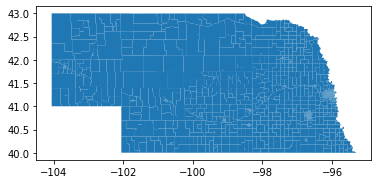

In [68]:
vest_ne_2020.plot()

<AxesSubplot:>

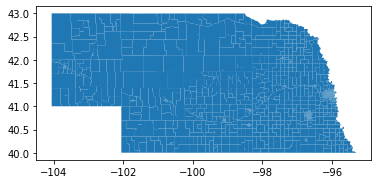

In [69]:
vest_ne_2020.plot()

In [70]:
races = [i for i in vest_ne_2020.columns if "G20P" in i]

## Build table of precinct-level election results from NE SOS Spreadsheets

Extract a master list of Nebraska counties using the 2020 Presidential results spreadsheet.

In [71]:
import xlrd
pres_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Presidential.xls', sheet_name='County Results', skiprows=5)

# throw out the bottom three rows (two rows of SOS formatting, one "total" row); extract county list.
pres_excel_df = pres_excel_df.loc[0:len(pres_excel_df)-4]
county_list = list(pres_excel_df['County'])

In [72]:
# The ends of the data tables are not consistent from sheet to sheet. 
# This function finds the correct ending row of a county data set, adds a 'County' column, 
# and returns a cleaned dataframe for this county. 
def clean_county_sheet(county_df, county_name):
    # Find the end of this data table by searching for the "TOTAL" row. 
    # Should return a list of exactly one number, which is the row index of the total row. 
    total_row_idx = list(county_excel_df.loc[county_excel_df['Precinct'] == 'TOTAL'].index)
    if len(total_row_idx) != 1:
        raise ValueError("Position of 'TOTAL' row could not be accurately inferred! (Found '{0}' suitable rows.)".format(len(total_row_idx)))

    # keep everything up to the total row 
    county_df = county_excel_df.loc[0:total_row_idx[0]-1].copy()
    county_df['County'] = county_name
    
    # clean leading/trailing whitespace from column names and precinct values
    county_df.columns = map(lambda e: e.strip(), list(county_df.columns))
    county_df['Precinct'] = county_df['Precinct'].apply(lambda e: e.strip())
    return county_df

Nebraska SOS distributes election results in spreadsheets, one for each statewide office on the ballot. Each county's results are broken down by precinct on a different page within the spreadsheet. 

In order to build a precinct-level data set of election results, we need to extract the precinct data from each master sheet (one for the presidential results, and one for the Senate results). Then we standardize the race results, and create one dataframe for each race. 

<b>NOTE:</b> 93 counties were missing one of the special precincts ('Countywide' or 'New/Former Resident') in their Senate race results, 1 county was missing a special precinct in its Presidential results. `ensure_special_precincts_exist(county_df, county_name, racetype)` fixes this problem by adding them back in where needed (with no votes).


In [73]:
# merge into below cell when finished 

# county_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Presidential.xls', sheet_name='Custer', skiprows=5)
# county_df = clean_county_sheet(county_excel_df, 'Custer')
# county_df = county_df.rename(columns=pres_race_map)
# county_df = county_df[['County', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR']]
# county_df = ensure_special_precincts_exist(county_df, 'Custer', 'PRESID')
# if not county_df['Precinct'].is_unique:
#     # when debugging is complete, merge everything below into def merge_duplicate_precincts(county_df, county_name):
    
#     print('merging duplicate precincts in {0} county'.format('Custer'))
    
#     # build a list of vote columns for this county.
#     # (This works for both Senate and Presidential after VEST race naming standards have been applied)
#     all_races = [e for e in pres_race_map.values()] + [e for e in sen_race_map.values()]
#     race_cols = list(filter(lambda e: e in all_races, list(county_df.columns)))
#     merged_precincts_df = county_df.groupby(['County', 'Precinct'], as_index=False)[race_cols].sum()
#     print(type(merged_precincts_df))

In [74]:
# G20PRERTRU - Donald J. Trump (Republican Party)
# G20PREDBID - Joseph R. Biden (Democratic Party)
# G20PRELJOR - Jo Jorgensen (Libertarian Party)
pres_race_map = {
    'Joseph R. Biden and Kamala D. Harris': 'G20PREDBID',
    'Donald J. Trump and Michael R. Pence': 'G20PRERTRU',
    'Jo Jorgensen and Jeremy Cohen': 'G20PRELJOR'
}

# G20USSRSAS - Ben Sasse (Republican Party)
# G20USSDJAN - Chris Janicek (Democratic Party)
# G20USSLSIA - Gene Siadek (Libertarian Party)
sen_race_map = {
    'Gene Siadek': 'G20USSLSIA',
    'Ben Sasse': 'G20USSRSAS',
    'Chris Janicek': 'G20USSDJAN'   
}

# If dataframe contains precinct names that are identical, return the county dataframe with such precincts merged. 
def merge_duplicate_precincts(county_df, county_name):
    # Merge the vote totals for every column that looks like a race. Leave county and precinct as-is.
    # (This works for both Senate and Presidential after VEST race naming standards have been applied)
    all_races = [e for e in pres_race_map.values()] + [e for e in sen_race_map.values()]
    race_cols = list(filter(lambda e: e in all_races, list(county_df.columns)))
    print('merged duplicate precincts in {0} county'.format(county_name))
    return county_df.groupby(['County', 'Precinct'], as_index=False)[race_cols].sum()
    
# complain about duplicate precincts within a county
def detect_duplicate_precincts(county_df, county_name, racetype):
    # check if there are duplicated precincts in this county 
    if not county_df['Precinct'].is_unique:
        print('{} / {}: duplicate precincts detected in county! '.format(racetype, county_name))
    
# Ensures that a row for the two special precincts "Countywide" and "New/Former Resident" exists in the county dataframe.
# When it isn't there, adds a row with zero votes for all races for each missing special precinct.
# If data for all special precincts exists, returns the county dataframe with no changes.
#
# racetype is just a flag that's used for formatting the debugging output of this function.
def ensure_special_precincts_exist(county_df, county_name, racetype):
    dfs_to_append = []
    special_precincts = ['Countywide', 'New/Former Resident']
    for sp in special_precincts:
        if sp not in county_df['Precinct'].values:
            new_row_dict = {}
            new_row_dict['County'] = county_name
            new_row_dict['Precinct'] = sp
            # set the vote count for each race to zero.
            for col_name in filter(lambda e: e not in new_row_dict.keys(), list(county_df.columns)):
                new_row_dict[col_name] = 0
            dfs_to_append.append(pd.Series(new_row_dict))
            #print('{} / County `{}` has no `{}` precinct!'.format(racetype, county_name, sp))
            #print('+ Appending row: {}'.format([df.to_dict() for df in dfs_to_append]))
    if len(dfs_to_append) > 1:
        return pd.concat(objs=([county_df] + dfs_to_append))
    elif len(dfs_to_append) == 1:
        return county_df.append(dfs_to_append[0], ignore_index=True)
    else:
        return county_df

# construct each precinct-level county dataframe
pres_county_dfs = []
sen_county_dfs = []
for county in county_list:
    county_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Presidential.xls', sheet_name=county, skiprows=5)
    county_df = clean_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=pres_race_map)
    county_df = county_df[['County', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR']]
    county_df = ensure_special_precincts_exist(county_df, county, 'PRESID')
    if not county_df['Precinct'].is_unique:
        county_df = merge_duplicate_precincts(county_df, county)
        pres_county_dfs.append(county_df.copy())
    else:
        pres_county_dfs.append(county_df.copy())
    #print("extracted '{0}' county presidential precinct results. (added '{1}' rows)".format(county, len(county_df)))
    
    # senate results
    county_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Senate.xls', sheet_name=county, skiprows=5)
    county_df = clean_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=sen_race_map)
    county_df = county_df[['County', 'Precinct', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']]
    county_df = ensure_special_precincts_exist(county_df, county, 'SENATE')
    if not county_df['Precinct'].is_unique:
        county_df = merge_duplicate_precincts(county_df, county)
        sen_county_dfs.append(county_df.copy())
    else:
        sen_county_dfs.append(county_df.copy())
    #print("extracted '{0}' county senate precinct results. (added '{1}' rows)".format(county, len(county_df)))

merged duplicate precincts in Custer county
merged duplicate precincts in Custer county


In [75]:
pres_results_df = pd.concat(pres_county_dfs).reset_index(drop=True)
sen_results_df = pd.concat(sen_county_dfs).reset_index(drop=True)
all_results_df = pres_results_df.merge(sen_results_df, how='left', left_on=['County', 'Precinct'], right_on=['County', 'Precinct'])

In [76]:
all_results_df.to_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv', index=False)

### Examination of Statewide Results 

Keeping track of data weirdness that may be breaking the joining process.

1. Dixon and Sarpy counties both have split "New/Former Resident" precincts. As of 10/8, I've merged the precincts together in the Nebraska SOS source spreadsheet.

> -- New/Former Resident 1 (Dixon, Sarpy)  <br>
> -- New/Former Resident 2 (Dixon, Sarpy) <br>

<b>NOTE:</b> Check with Peter to determine if modifying source data is the best practice for a situation like this. I could merge it later in the pipeline if source data from state governments must remain as-is.


2. Need to check to see if VEST lists these precincts in a single "Countywide" category, and merge them if so.

> -- (Countywide) Burt County PPD (Dodge) <br>
> -- (Countywide) Cuming PPD (Dodge, Wayne) <br>
> -- (Countywide) Nebraska PPD (Garden, Sheridan) <br>
> -- (Countywide) Loup Valleys Rural PPD (Greeley) <br>
> -- (Countywide) Elkhorn Rural PPD (Platte) <br>

3. Have to merge duplicated county precincts!

In [77]:
er_2020_df = pd.read_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv')

In [78]:
# Show all possible precinct names and list them with their corresponding counties 
for p in er_2020_df['Precinct'].unique():
    including_row = er_2020_df.loc[er_2020_df['Precinct'] == p]
    source_county = including_row['County']
    print('-- {} ({})'.format(p, ', '.join(source_county.values)))

-- WestBlue/Highland (Adams)
-- Verona (Adams)
-- Kenesaw (Adams)
-- Juniata (Adams)
-- Denver (Adams)
-- Blaine (Adams, Blaine)
-- Pauline (Adams)
-- Ayr (Adams)
-- Roseland (Adams)
-- Holstein (Adams)
-- 1-A (Adams)
-- 1-B (Adams)
-- 1-C (Adams)
-- 2-A (Adams)
-- 2-B (Adams)
-- 2-C (Adams)
-- 2-D (Adams)
-- 2-E (Adams)
-- 3-A (Adams)
-- 3-B (Adams)
-- 3-C (Adams)
-- 3-D (Adams)
-- 3-E (Adams)
-- 4-A (Adams)
-- 4-B (Adams)
-- 4-C (Adams)
-- 4-D (Adams)
-- 4-E (Adams)
-- New/Former Resident (Adams, Antelope, Arthur, Banner, Blaine, Boone, Box Butte, Boyd, Brown, Buffalo, Burt, Butler, Cass, Cedar, Chase, Cherry, Cheyenne, Clay, Colfax, Cuming, Custer, Dakota, Dawes, Dawson, Deuel, Dixon, Dodge, Douglas, Dundy, Fillmore, Franklin, Frontier, Furnas, Gage, Garden, Garfield, Gosper, Grant, Greeley, Hall, Hamilton, Harlan, Hayes, Hitchcock, Holt, Hooker, Howard, Jefferson, Johnson, Kearney, Keith, Keya Paha, Kimball, Knox, Lancaster, Lincoln, Logan, Loup, Madison, McPherson, Merrick, Morril

-- 04-05 (Douglas)
-- 04-06 (Douglas)
-- 04-07 (Douglas)
-- 04-08 (Douglas)
-- 04-09 (Douglas)
-- 04-10 (Douglas)
-- 04-11 (Douglas)
-- 04-12 (Douglas)
-- 04-13 (Douglas)
-- 04-14 (Douglas)
-- 04-15 (Douglas)
-- 04-16 (Douglas)
-- 04-17 (Douglas)
-- 04-18 (Douglas)
-- 04-19 (Douglas)
-- 04-20 (Douglas)
-- 04-21 (Douglas)
-- 05-01 (Douglas)
-- 05-02 (Douglas)
-- 05-03 (Douglas)
-- 05-05 (Douglas)
-- 05-06 (Douglas)
-- 05-07 (Douglas)
-- 05-09 (Douglas)
-- 05-10 (Douglas)
-- 05-11 (Douglas)
-- 05-12 (Douglas)
-- 05-13 (Douglas)
-- 05-14 (Douglas)
-- 05-15 (Douglas)
-- 05-16 (Douglas)
-- 05-17 (Douglas)
-- 05-18 (Douglas)
-- 05-19 (Douglas)
-- 05-23 (Douglas)
-- 05-24 (Douglas)
-- 05-25 (Douglas)
-- 05-26 (Douglas)
-- 05-27 (Douglas)
-- 05-28 (Douglas)
-- 05-30 (Douglas)
-- 05-31 (Douglas)
-- 05-32 (Douglas)
-- 05-33 (Douglas)
-- 05-34 (Douglas)
-- 05-35 (Douglas)
-- 05-36 (Douglas)
-- 06-02 (Douglas)
-- 06-03 (Douglas)
-- 06-04 (Douglas)
-- 06-07 (Douglas)
-- 06-08 (Douglas)
-- 06-09 (Do

-- 9 E-4 (Lancaster)
-- 9 E-5 (Lancaster)
-- 9 F-1 (Lancaster)
-- 9 F-2 (Lancaster)
-- 9 F-3 (Lancaster)
-- 9 F-4 (Lancaster)
-- 9 F-5 (Lancaster)
-- 9 F-9 (Lancaster)
-- 9 F-10 (Lancaster)
-- 9 F-11 (Lancaster)
-- 9 G-1 (Lancaster)
-- 9 G-2 (Lancaster)
-- 9 G-3 (Lancaster)
-- 9 G-4 (Lancaster)
-- 9 G-5 (Lancaster)
-- 9 G-6 (Lancaster)
-- 9 G-7 (Lancaster)
-- 9 G-8 (Lancaster)
-- 9 G-9 (Lancaster)
-- 9 H-1 (Lancaster)
-- 9 H-2 (Lancaster)
-- 9 H-3 (Lancaster)
-- 9 H-4 (Lancaster)
-- 9 H-5 (Lancaster)
-- 9 H-6 (Lancaster)
-- 9 H-7 (Lancaster)
-- 9 H-8 (Lancaster)
-- 10 A (Lancaster)
-- 10 B-1 (Lancaster)
-- 10 B-2 (Lancaster)
-- 10 B-4 (Lancaster)
-- 10 B-5 (Lancaster)
-- 10 C-4 (Lancaster)
-- 10 C-5 (Lancaster)
-- 10 C-6 (Lancaster)
-- 10 C-7 (Lancaster)
-- 10 C-8 (Lancaster)
-- 10 C-12 (Lancaster)
-- 10 D-1 (Lancaster)
-- 10 D-2 (Lancaster)
-- 10 D-3 (Lancaster)
-- 10 D-4 (Lancaster)
-- 10 D-8 (Lancaster)
-- 10 E-1 (Lancaster)
-- 10 E-4 (Lancaster)
-- 10 E-5 (Lancaster)
-- 10 E-7 (Lan

-- Ashland Rural (Saunders)
-- Yutan (Saunders)
-- Castle Rock A (Scotts Bluff)
-- Castle Rock B (Scotts Bluff)
-- Dewey-Tabor (Scotts Bluff)
-- East Winter Creek (Scotts Bluff)
-- Fanning (Scotts Bluff)
-- Ford A & B (Scotts Bluff)
-- Funston (Scotts Bluff)
-- Gering (Rural) (Scotts Bluff)
-- Gering I (Scotts Bluff)
-- Gering II (Scotts Bluff)
-- Gering III (Scotts Bluff)
-- Gering IV (Scotts Bluff)
-- Highland (Scotts Bluff)
-- Kiowa-Lyman (Scotts Bluff)
-- Minatare I & II (Scotts Bluff)
-- Mitchell (Rural) (Scotts Bluff)
-- Mitchell I (Scotts Bluff)
-- Mitchell II (Scotts Bluff)
-- Morrill (Scotts Bluff)
-- Roubadeau (Scotts Bluff)
-- Scottsbluff 1 (Scotts Bluff)
-- Scottsbluff 2 (Scotts Bluff)
-- Scottsbluff 3 (Scotts Bluff)
-- Scottsbluff 4 (Scotts Bluff)
-- Scottsbluff 5 (Scotts Bluff)
-- Scottsbluff 6 (Scotts Bluff)
-- Scottsbluff 7 (Scotts Bluff)
-- Scottsbluff 8 (Scotts Bluff)
-- Terrytown I & II (Scotts Bluff)
-- West Winter Creek (Scotts Bluff)
-- B (Seward)
-- C (Seward)
--

In [79]:
er_2020_df.loc[er_2020_df['County'] == 'Custer']

,County,Precinct,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDJAN,G20USSRSAS,G20USSLSIA
259,Custer,ANSELMO,26.0,219.0,2.0,12.0,207.0,16.0
260,Custer,ANSLEY/M/W,51.0,395.0,10.0,34.0,374.0,29.0
261,Custer,ARNOLD,44.0,420.0,4.0,40.0,379.0,24.0
262,Custer,BB NORTHWEST,0.0,0.0,0.0,0.0,0.0,0.0
263,Custer,BB SOUTH RURAL,0.0,0.0,0.0,0.0,0.0,0.0
264,Custer,BERWYN,13.0,127.0,6.0,11.0,118.0,11.0
265,Custer,BROKEN BOW NORTH,48.0,130.0,7.0,27.0,142.0,12.0
266,Custer,BROKEN BOW NORTH RURAL,34.0,211.0,6.0,18.0,201.0,13.0
267,Custer,BROKEN BOW NORTHWEST,94.0,430.0,15.0,59.0,420.0,30.0
268,Custer,BROKEN BOW SOUTH,135.0,517.0,18.0,88.0,512.0,45.0


### Load in Raw Election Results

NOTE: This is just the file we created in the "Build table of precinct-level election results from NE SOS Spreadsheets" section above. 

In [80]:
er_2020_df = pd.read_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv')

In [81]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

### Validate statewide totals

In [82]:
races = ['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']
statewide_totals_check(er_2020_df,vest_ne_2020,races)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 374583.0
G20PRERTRU is equal 	VEST / RDH: 556846.0
G20PRELJOR is equal 	VEST / RDH: 20283.0
G20USSDJAN is equal 	VEST / RDH: 227191.0
G20USSRSAS is equal 	VEST / RDH: 583507.0
G20USSLSIA is equal 	VEST / RDH: 55115.0


Convert 'County' column on our results to a FIPS column.

In [83]:
fips_df = pd.read_csv('../raw-from-source/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2020_df['FIPS'] = er_2020_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2020_df = er_2020_df[['FIPS', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']]
er_2020_df = er_2020_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ne_2020_df = er_2020_df[['COUNTY', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']]

'Cherry'

In [84]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

### Validate County Totals

In [85]:
county_totals_check(vest_ne_2020, ne_2020_df, races, 'COUNTY', full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU is equal across all counties
G20PRELJOR is equal across all counties
G20USSDJAN is equal across all counties
G20USSRSAS is equal across all counties
G20USSLSIA is equal across all counties


In [86]:
# vest_ne_2020.loc[vest_ne_2020['COUNTY'] == '041']

In [87]:
# er_2020_df.loc[er_2020_df['COUNTY'] == '041']

### Precinct Validation

Do prep work before merging

In [134]:
# converts FIPS value corresponding to a county within Nebraska to its county name
fips_df = pd.read_csv('../raw-from-source/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_padded_list = list(map(lambda e: str(e).zfill(3), fl['FIPS County']))
fips_dict = dict(zip(fips_padded_list, fl['County Name']))

In [135]:
# uppercase all precinct names in both frames
ne_2020_df['NAME'] = ne_2020_df['NAME'].apply(lambda e: e.upper())
vest_ne_2020['NAME'] = vest_ne_2020['NAME'].apply(lambda e: e.upper())

In [152]:
ne_2020_df.to_csv('../raw-from-source/2020-er/unjoined_ne_2020.csv', index=False)
vest_ne_2020.to_csv('../raw-from-source/2020-er/unjoined_vest_2020.csv', index=False)

Perform merge and check the results

In [136]:
merged_df = pd.merge(vest_ne_2020, ne_2020_df, how='left',on=['COUNTY', 'NAME'], indicator=True, validate='1:1')

In [137]:
# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merged_df[merged_df.isnull().any(axis=1)]
valid_rows = merged_df[~merged_df.isnull().any(axis=1)]
print('NaN rows: {0}, Valid rows: {1} -> joined {2}%'.format(len(nan_rows), len(valid_rows), (len(valid_rows)/(len(nan_rows)+len(valid_rows)))*100))

NaN rows: 1033, Valid rows: 353 -> joined 25.46897546897547%


In [150]:
# build county by county join stats and write them to disk 
county_join_stats = [] 
counties = list(ne_2020_df['COUNTY'].unique())
for county in counties:
    county_df = merged_df.loc[merged_df['COUNTY'] == county]
    nan_rows = county_df[county_df.isnull().any(axis=1)]
    valid_rows = county_df[~county_df.isnull().any(axis=1)]
    pcnt_merged = round(len(valid_rows)/(len(nan_rows)+len(valid_rows))*100, 2)
    r = (fips_dict[county], county, len(valid_rows), len(valid_rows)+len(nan_rows), pcnt_merged)
    county_join_stats.append(r)
    
county_stats_df = pd.DataFrame(county_join_stats, columns=['County Name', 'FIPS County', 'Precincts Joined', 'Total Precincts', 'Percent Merged'])
county_stats_df = county_stats_df.sort_values('Percent Merged', ascending=False)
county_stats_df.to_csv('../raw-from-source/2020-er/joined-stats-by-county.csv', index=False)


In [145]:
merged_df

,COUNTY,NAME,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20USSRSAS_x,G20USSDJAN_x,G20USSLSIA_x,geometry,G20PRERTRU_y,G20PREDBID_y,G20PRELJOR_y,G20USSRSAS_y,G20USSDJAN_y,G20USSLSIA_y,_merge
0,057,BENKELMAN I/OUGH,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101....",NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,057,BENKELMAN II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101....",294.0,23.0,5.0,281.0,15.0,14.0,both
2,057,BENKELMAN III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101....",146.0,14.0,0.0,136.0,9.0,7.0,both
3,057,HAIGLER,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102....",109.0,17.0,3.0,110.0,10.0,7.0,both
4,017,CITY OF AINSWORTH PRECINCT,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87...",NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99...",538.0,834.0,18.0,642.0,467.0,67.0,both
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ...",736.0,938.0,47.0,833.0,604.0,104.0,both
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14...",564.0,658.0,26.0,657.0,402.0,51.0,both
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10...",1101.0,434.0,24.0,1165.0,239.0,78.0,both


check precinct values.

In [94]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [95]:
all_races = [e for e in pres_race_map.values()] + [e for e in sen_race_map.values()]
precinct_votes_check(merged_df, all_races, True, 'NAME')

FIX NaN value at:  #1 PRECINCT


# Peter's 1:1 examples start below this line

In [24]:
vest_ne_2020.columns

Index(['COUNTY', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA', 'geometry'],
      dtype='object')

In [17]:
er_2020_df["office"].unique()

array(['State House', 'President', 'Senate'], dtype=object)

In [18]:
er_2020_filtered = er_2020_df[er_2020_df["office"].isin(['President'])]

In [19]:
er_2020_filtered["candidate"].unique()

array(['Joseph R. Biden and Kamala D. Harris',
       'Donald J. Trump and Michael R. Pence',
       'Jo Jorgensen and Jeremy Cohen'], dtype=object)

In [22]:
er_2020_filtered["candidate"].unique()

array(['Joseph R. Biden and Kamala D. Harris',
       'Donald J. Trump and Michael R. Pence',
       'Jo Jorgensen and Jeremy Cohen'], dtype=object)

In [23]:
cand_name_changes = {'Donald J. Trump and Michael R. Pence':'G20PRERTRU', 
'Joseph R. Biden and Kamala D. Harris':'G20PREDBID',
'Jo Jorgensen and Jeremy Cohen':'G20PRELJOR'}

er_2020_filtered["candidate"] = er_2020_filtered["candidate"].map(cand_name_changes)

<ipython-input-23-ae8e257cbf98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er_2020_filtered["candidate"] = er_2020_filtered["candidate"].map(cand_name_changes)


In [24]:
er_2020_filtered["candidate"].unique()

array(['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR'], dtype=object)

In [25]:
er_2020_filtered

,county,precinct,office,district,party,candidate,votes
2651,Adams,WestBlue/Highland,President,NaN,NaN,G20PREDBID,50.0
2652,Adams,WestBlue/Highland,President,NaN,NaN,G20PRERTRU,335.0
2653,Adams,WestBlue/Highland,President,NaN,NaN,G20PRELJOR,4.0
2654,Adams,Verona,President,NaN,NaN,G20PREDBID,24.0
2655,Adams,Verona,President,NaN,NaN,G20PRERTRU,131.0
...,...,...,...,...,...,...,...
7413,York,New/Former Resident,President,NaN,NaN,G20PRERTRU,4.0
7414,York,New/Former Resident,President,NaN,NaN,G20PRELJOR,0.0
7415,York,Countywide,President,NaN,NaN,G20PREDBID,0.0
7416,York,Countywide,President,NaN,NaN,G20PRERTRU,0.0


In [26]:
er_2020_filtered["pivot_id"] = er_2020_filtered["county"]+"-"+er_2020_filtered["precinct"]

<ipython-input-26-650513afc260>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er_2020_filtered["pivot_id"] = er_2020_filtered["county"]+"-"+er_2020_filtered["precinct"]


In [28]:
er_2020_filtered

,county,precinct,office,district,party,candidate,votes,pivot_id
2651,Adams,WestBlue/Highland,President,NaN,NaN,G20PREDBID,50.0,Adams-WestBlue/Highland
2652,Adams,WestBlue/Highland,President,NaN,NaN,G20PRERTRU,335.0,Adams-WestBlue/Highland
2653,Adams,WestBlue/Highland,President,NaN,NaN,G20PRELJOR,4.0,Adams-WestBlue/Highland
2654,Adams,Verona,President,NaN,NaN,G20PREDBID,24.0,Adams-Verona
2655,Adams,Verona,President,NaN,NaN,G20PRERTRU,131.0,Adams-Verona
...,...,...,...,...,...,...,...,...
7413,York,New/Former Resident,President,NaN,NaN,G20PRERTRU,4.0,York-New/Former Resident
7414,York,New/Former Resident,President,NaN,NaN,G20PRELJOR,0.0,York-New/Former Resident
7415,York,Countywide,President,NaN,NaN,G20PREDBID,0.0,York-Countywide
7416,York,Countywide,President,NaN,NaN,G20PRERTRU,0.0,York-Countywide


In [66]:

er_2020_pivoted = pd.pivot_table(er_2020_filtered,index=["pivot_id","precinct","county"],columns=["candidate"],values=['votes'],aggfunc=sum)

In [67]:
er_2020_pivoted.reset_index(inplace=True,drop=False)

In [68]:
er_2020_pivoted.droplevel(1)

IndexError: Too many levels: Index has only 1 level, not 2

In [55]:
er_2020_pivoted.columns = er_2020_pivoted.columns.droplevel(0)

In [70]:
er_2020_pivoted.columns = ["unique_ID","NAME","COUNTY",'G20PREDBID', 'G20PRELJOR', 'G20PRERTRU']

In [71]:
er_2020_pivoted

,unique_ID,NAME,COUNTY,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,1~A,Adams,252.0,20.0,570.0
1,Adams-1~B,1~B,Adams,187.0,15.0,401.0
2,Adams-1~C,1~C,Adams,222.0,12.0,297.0
3,Adams-2~A,2~A,Adams,77.0,9.0,258.0
4,Adams-2~B,2~B,Adams,176.0,18.0,458.0
...,...,...,...,...,...,...
1579,York-Ward 2A,Ward 2A,York,162.0,18.0,413.0
1580,York-Ward 2B,Ward 2B,York,155.0,25.0,407.0
1581,York-Ward 3,Ward 3,York,154.0,13.0,317.0
1582,York-Ward 4A,Ward 4A,York,215.0,27.0,566.0


In [58]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [43]:
statewide_totals_check(er_2020_pivoted,vest_ne_2020,races)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 556846.0
G20PREDBID is equal 	VEST / RDH: 374583.0
G20PRELJOR is equal 	VEST / RDH: 20283.0


KeyError: 'G20USSRSAS'

In [44]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [45]:
vest_ne_2020

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
0,057,Benkelman I/Ough,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101...."
1,057,Benkelman II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101...."
2,057,Benkelman III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101...."
3,057,Haigler,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102...."
4,017,City of Ainsworth Precinct,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87..."
...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99..."
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ..."
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14..."
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10..."


In [46]:
er_2020_pivoted

,unique_ID,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,252.0,20.0,570.0
1,Adams-1~B,187.0,15.0,401.0
2,Adams-1~C,222.0,12.0,297.0
3,Adams-2~A,77.0,9.0,258.0
4,Adams-2~B,176.0,18.0,458.0
...,...,...,...,...
1579,York-Ward 2A,162.0,18.0,413.0
1580,York-Ward 2B,155.0,25.0,407.0
1581,York-Ward 3,154.0,13.0,317.0
1582,York-Ward 4A,215.0,27.0,566.0


In [48]:
vest_ne_2020["unique_ID"] = vest_ne_2020["COUNTY"]+"-"+vest_ne_2020["NAME"]

In [50]:
#Attempt to merge
merge_attempt_one = pd.merge(vest_ne_2020,er_2020_pivoted,how="outer",indicator=True,validate="1:1")

In [51]:
merge_attempt_one["_merge"].value_counts()

right_only    1584
left_only     1386
both             0
Name: _merge, dtype: int64

In [63]:
list(er_2020_pivoted["NAME"].unique())

['1~A',
 '1~B',
 '1~C',
 '2~A',
 '2~B',
 '2~C',
 '2~D',
 '2~E',
 '3~A',
 '3~B',
 '3~C',
 '3~D',
 '3~E',
 '4~A',
 '4~B',
 '4~C',
 '4~D',
 '4~E',
 'Ayr',
 'Blaine',
 'Countywide',
 'Denver',
 'Holstein',
 'Juniata',
 'Kenesaw',
 'New/Former Resident',
 'Pauline',
 'Roseland',
 'Verona',
 'WestBlue/Highland',
 'Brunswick Precinct',
 'Clearwater Precinct',
 'Elgin 1st Ward',
 'Elgin 2nd Ward',
 'Elgin Precinct',
 'Neligh 1st Ward',
 'Neligh 2nd Ward',
 'Neligh Precinct',
 'Oakdale Precinct',
 'Orchard Precinct',
 'Royal Precinct',
 'Tilden 1st Ward',
 'Tilden Precinct',
 'Arthur',
 'Long Springs',
 'Beaver',
 'Boone',
 'Cedar',
 'Dublin~Bonanza',
 'North Branch~Shell Creek',
 'North Manchester',
 'Oakland',
 'Southeast Manchester',
 'Southwest Manchester',
 'Precinct 1',
 'Precinct 11',
 'Precinct 12',
 'Precinct 15',
 'Precinct 2',
 'Precinct 3',
 'Precinct 4',
 'Precinct 5',
 'Precinct 6',
 'Butte Basin McCulley',
 'Lynch Bristow Mullen Bush',
 'Spencer Morton',
 'Ainsworth Precinct',
 '

In [72]:
er_2020_countywide = er_2020_pivoted[er_2020_pivoted["NAME"]=='Countywide']
er_2020_precinct = er_2020_pivoted[er_2020_pivoted["NAME"]!='Countywide']

In [73]:
er_2020_pivoted

,unique_ID,NAME,COUNTY,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,1~A,Adams,252.0,20.0,570.0
1,Adams-1~B,1~B,Adams,187.0,15.0,401.0
2,Adams-1~C,1~C,Adams,222.0,12.0,297.0
3,Adams-2~A,2~A,Adams,77.0,9.0,258.0
4,Adams-2~B,2~B,Adams,176.0,18.0,458.0
...,...,...,...,...,...,...
1579,York-Ward 2A,Ward 2A,York,162.0,18.0,413.0
1580,York-Ward 2B,Ward 2B,York,155.0,25.0,407.0
1581,York-Ward 3,Ward 3,York,154.0,13.0,317.0
1582,York-Ward 4A,Ward 4A,York,215.0,27.0,566.0


In [77]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [78]:
ne_allocated = allocate_absentee(er_2020_precinct,er_2020_countywide,races,"COUNTY")

In [81]:
sum(er_2020_precinct["G20PREDBID"])

374562

In [82]:
sum(ne_allocated["G20PREDBID"])

374562